<a href="https://colab.research.google.com/github/sirkyven/python-workbook/blob/master/NLP_for_babies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
!pip install kaggle
!pip install pathlib
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
!pip install nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00


In [3]:
creds = '{"username":"disisvenky","key":"ff71e08c488c15a62d070bffcf75ee67"}'

In [4]:
from pathlib import Path
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
#if not cred_path.exists():
cred_path.parent.mkdir(exist_ok=True)
cred_path.write_text(creds)
cred_path.chmod(0o600)

In [5]:
path =  Path('us-patent-phrase-to-phrase-matching')

In [6]:
if not iskaggle and not path.exists():
  import zipfile,kaggle
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

In [7]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [8]:
import pandas as pd

In [9]:
df = pd.read_csv(path/'train.csv')

In [10]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [11]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [12]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1:' + df.anchor

In [13]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1:abatement
2    TEXT1: A47; TEXT2: active catalyst; ANC1:abate...
3    TEXT1: A47; TEXT2: eliminating process; ANC1:a...
4     TEXT1: A47; TEXT2: forest region; ANC1:abatement
Name: input, dtype: object

In [14]:
from datasets import Dataset,DatasetDict
ds = Dataset.from_pandas(df)

In [15]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [16]:
model_nm = 'microsoft/deberta-v3-small'

In [17]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [19]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [20]:
def tok_func(x): return tokz(x["input"])

In [27]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [28]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1:abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  16191,
  297,
  17019,
  2])

In [30]:
tokz.tokenize(row['input'])

['▁TEXT',
 '1',
 ':',
 '▁A',
 '47',
 ';',
 '▁TEXT',
 '2',
 ':',
 '▁abatement',
 '▁of',
 '▁pollution',
 ';',
 '▁ANC',
 '1',
 ':',
 'aba',
 't',
 'ement']

In [40]:
tokz.vocab['▁ANC']

23702

In [41]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [42]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [43]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [44]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [45]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [51]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [56]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

In [52]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [53]:
def corr(x,y): return np.corrcoef(x,y)[0][1]
corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906

In [54]:
def show_corr(df, a, b):
  x, y = df[a], df[b]
  plt.scatter(x, y, alpha=0.5, s=4)
  plt.title(f'{a} vs {b}; r: {corr(x,y):.2f}')

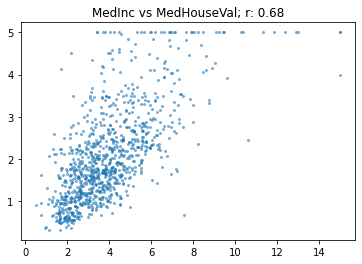

In [57]:
show_corr(housing, 'MedInc', 'MedHouseVal')

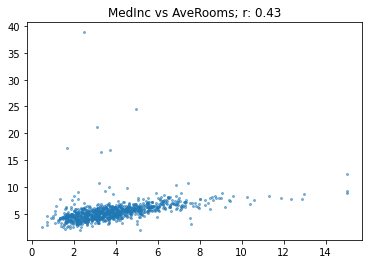

In [58]:
show_corr(housing, 'MedInc', 'AveRooms')

In [59]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [60]:
from transformers import TrainingArguments, Trainer
bs = 128
epochs = 4
lr = 8e-5

In [64]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True, evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [65]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [66]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, target, input, anchor, id. If context, target, input, anchor, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856
  Number of trainable parameters = 141895681
You're using a DebertaV2TokenizerFast tokenizer. Please note that wi

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025515,0.783541
2,No log,0.028142,0.816081
3,0.035000,0.023498,0.827632
4,0.035000,0.023615,0.828372


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, target, input, anchor, id. If context, target, input, anchor, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, target, input, anchor, id. If context, target, input, anchor, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved 

TrainOutput(global_step=856, training_loss=0.026280761322128438, metrics={'train_runtime': 78.1856, 'train_samples_per_second': 1399.439, 'train_steps_per_second': 10.948, 'total_flos': 719784762340080.0, 'train_loss': 0.026280761322128438, 'epoch': 4.0})

In [67]:
preds = trainer.predict(eval_ds).predictions.astype(float)

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, target, input, anchor, id. If context, target, input, anchor, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 256


In [68]:
preds

array([[ 0.51],
       [ 0.71],
       [ 0.58],
       [ 0.38],
       [-0.  ],
       [ 0.51],
       [ 0.53],
       [-0.03],
       [ 0.31],
       [ 1.12],
       [ 0.28],
       [ 0.28],
       [ 0.78],
       [ 0.81],
       [ 0.77],
       [ 0.47],
       [ 0.29],
       [-0.03],
       [ 0.62],
       [ 0.35],
       [ 0.35],
       [ 0.26],
       [ 0.08],
       [ 0.25],
       [ 0.58],
       [-0.04],
       [-0.04],
       [-0.02],
       [-0.04],
       [ 0.57],
       [ 0.3 ],
       [ 0.01],
       [ 0.69],
       [ 0.4 ],
       [ 0.46],
       [ 0.19]])

In [69]:
preds = np.clip(preds, 0, 1)

In [70]:
preds

array([[0.51],
       [0.71],
       [0.58],
       [0.38],
       [0.  ],
       [0.51],
       [0.53],
       [0.  ],
       [0.31],
       [1.  ],
       [0.28],
       [0.28],
       [0.78],
       [0.81],
       [0.77],
       [0.47],
       [0.29],
       [0.  ],
       [0.62],
       [0.35],
       [0.35],
       [0.26],
       [0.08],
       [0.25],
       [0.58],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.57],
       [0.3 ],
       [0.01],
       [0.69],
       [0.4 ],
       [0.46],
       [0.19]])

In [71]:
import datasets
submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

855